# Generate protein with Galactica + retrieval

## Retrieve associated with proteins with the input condition

In [1]:
import pandas as pd
import os, json
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5,6,7"
import torch
import numpy as np
# retrieve relevant proteins by inputting the target disease
# input_disease = "malignant lymphoma"

In [2]:
df_dis = pd.read_csv("./data/Processed/disease.csv")

In [3]:
df_dis["mondo_name"].value_counts()[200:250]

mondo_name
Duchenne muscular dystrophy                   14
myositis                                      14
hypothyroidism, congenital, nongoitrous, 2    14
spondylolisthesis (disease)                   14
autoimmune thrombocytopenic purpura           14
respiratory failure                           14
scleroderma (disease)                         14
central nervous system disease                14
inherited aplastic anemia                     14
HELLP syndrome                                14
precocious puberty                            14
gastroesophageal reflux disease               14
sick sinus syndrome                           14
peptic esophagitis                            14
sex differentiation disease                   14
Chediak-Higashi syndrome                      14
vulvovaginitis                                14
bronchitis                                    14
hereditary persistence of fetal hemoglobin    14
agnosia                                       14
drug-indu

In [4]:
df_dis[df_dis["mondo_name"] == "breast cancer"]

,node_index,mondo_id,mondo_name,definition
15452,36691,7254,breast cancer,A primary or metastatic malignant neoplasm inv...
15453,36691,7254,breast cancer,A primary or metastatic malignant neoplasm inv...
15454,36691,7254,breast cancer,A primary or metastatic malignant neoplasm inv...
15455,36691,7254,breast cancer,A primary or metastatic malignant neoplasm inv...


In [5]:
# dis = df_dis[df_dis["mondo_id"] == 5062].iloc[0]
# dis
dis = df_dis[df_dis["mondo_name"] == "breast cancer"].iloc[0]
dis

node_index                                                36691
mondo_id                                                   7254
mondo_name                                        breast cancer
definition    A primary or metastatic malignant neoplasm inv...
Name: 15452, dtype: object

In [6]:
# load dis emb
import pickle
with open("/home/ec2-user/data/embeddings/esm2b_unimo_pubmedbert/disease.pkl","rb") as f:
    raw_dis = pickle.load(f)
raw_dis.keys()

dict_keys(['node_index', 'embedding'])

In [7]:
dis_node_index = np.array(raw_dis["node_index"])
dis_node_emb =  np.array(raw_dis["embedding"])

In [8]:
dis_node_emb.shape

(17080, 768)

In [9]:
dis_raw_emb = dis_node_emb[dis_node_index==dis["node_index"]]

In [10]:
# load bridge model
from src.model import BindingModel
from src.inference import BridgeInference
checkpoint_dir = "./checkpoints/bind-openke-benchmark-6-layer-unimol"
with open(os.path.join(checkpoint_dir, "model_config.json"), "r") as f:
    model_config = json.load(f)
model = BindingModel(**model_config)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "pytorch_model.bin")))
model = BridgeInference(model)

In [11]:
# transform disease emb to protein space
tr_pro_emb = model.transform(
    x = torch.tensor(dis_raw_emb),
    src_type = 2, # disease
    tgt_type = 1, # protein
    rel_type = 6, # associate with
)

In [12]:
# load pre-encoded protein embeddings and project for retrieval
with open("./data/embeddings/esm2b_unimo_pubmedbert/protein.pkl", "rb") as f:
    pro_raw = pickle.load(f)
pro_emb = torch.tensor(pro_raw["embedding"], dtype=torch.float32)
pro_emb = model.project(
    x = pro_emb,
    src_type = 1,
)
pro_idx = torch.tensor(pro_raw["node_index"])
df_pro = pd.read_csv("/home/ec2-user/data/Processed/protein.csv")

In [13]:
def retrieve_topk_protein(tgt, topk=10):
    """Args:
    tgt: emb with [1, dim]
    """
    cossim = torch.cosine_similarity(tgt, pro_emb, dim=1)
    top_k = torch.topk(cossim, k=topk, dim=0)
    retrieved = df_pro.set_index('node_index').loc[pro_idx[top_k.indices].numpy()]
    return retrieved

In [14]:
res_pro = retrieve_topk_protein(tr_pro_emb, 20)
for v in res_pro["node_name"]:
    print(v)
for v in res_pro["sequence"]:
    print(v)

BRCA2
NOTCH2
NOTCH1
TYMS
EGFR
NOTCH3
TP53
CDKN2A
CDKN2A
ESR2
NCOA1
ERBB2
NCOA3
TERT
KDR
FLT1
HIF1A
RAD51
BRCA1
PTGS2
JAG1
MPIGSKERPTFFEIFKTRCNKADLGPISLNWFEELSSEAPPYNSEPAEESEHKNNNYEPNLFKTPQRKPSYNQLASTPIIFKEQGLTLPLYQSPVKELDKFKLDLGRNVPNSRHKSLRTVKTKMDQADDVSCPLLNSCLSESPVVLQCTHVTPQRDKSVVCGSLFHTPKFVKGRQTPKHISESLGAEVDPDMSWSSSLATPPTLSSTVLIVRNEEASETVFPHDTTANVKSYFSNHDESLKKNDRFIASVTDSENTNQREAASHGFGKTSGNSFKVNSCKDHIGKSMPNVLEDEVYETVVDTSEEDSFSLCFSKCRTKNLQKVRTSKTRKKIFHEANADECEKSKNQVKEKYSFVSEVEPNDTDPLDSNVANQKPFESGSDKISKEVVPSLACEWSQLTLSGLNGAQMEKIPLLHISSCDQNISEKDLLDTENKRKKDFLTSENSLPRISSLPKSEKPLNEETVVNKRDEEQHLESHTDCILAVKQAISGTSPVASSFQGIKKSIFRIRESPKETFNASFSGHMTDPNFKKETEASESGLEIHTVCSQKEDSLCPNLIDNGSWPATTTQNSVALKNAGLISTLKKKTNKFIYAIHDETSYKGKKIPKDQKSELINCSAQFEANAFEAPLTFANADSGLLHSSVKRSCSQNDSEEPTLSLTSSFGTILRKCSRNETCSNNTVISQDLDYKEAKCNKEKLQLFITPEADSLSCLQEGQCENDPKSKKVSDIKEEVLAAACHPVQHSKVEYSDTDFQSQKSLLYDHENASTLILTPTSKDVLSNLVMISRGKESYKMSDKLKGNNYESDVELTKNIPMEKNQDVCALNENYKNVELLPPEKYMRVASPSRKVQFNQNTNLRVIQKNQEETTSISKITVNPD

## Generate with prompt

In [15]:
import torch
from transformers import AutoTokenizer, OPTForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("GeorgiaTechResearchInstitute/galactica-30b-evol-instruct-70k")
model = AutoModelForCausalLM.from_pretrained("GeorgiaTechResearchInstitute/galactica-30b-evol-instruct-70k", device_map="auto", torch_dtype=torch.bfloat16, cache_dir="/home/ec2-user/checkpoints")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/ec2-user/miniconda3/envs/py39/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/home/ec2-user/miniconda3/envs/py39/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /home/ec2-user/miniconda3/envs/py39 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
def generate_answer(input_text, max_new_tokens=128, temperature=0.7, top_k=40):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(input_ids, max_new_tokens=max_new_tokens,
                            top_k=top_k,
                            do_sample=True,
                            temperature=temperature,
                            repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0])

In [51]:
prompt_template = """### Instruction:
{instruction}

### Response: [START_I_SMILES]"""

prompt = prompt_template.format_map(
    {"instruction":f"""
    We want to design a drug, which can be targeting one of the following proteins:
    
    BRCA2 - Breast Cancer 2, Early Onset
    NOTCH2 - Notch Receptor 2
    NOTCH1 - Notch Receptor 1
    TYMS - Thymidylate Synthetase
    EGFR - Epidermal Growth Factor Receptor
    NOTCH3 - Notch Receptor 3
    TP53 - Tumor Protein p53
    CDKN2A - Cyclin-Dependent Kinase Inhibitor 2A
    ESR2 - Estrogen Receptor 2
    NCOA1 - Nuclear Receptor Coactivator 1
    ERBB2 - Erb-B2 Receptor Tyrosine Kinase 2 (also known as HER2)
    NCOA3 - Nuclear Receptor Coactivator 3
    TERT - Telomerase Reverse Transcriptase
    KDR - Kinase Insert Domain Receptor (also known as VEGFR2)
    FLT1 - Fms-Related Tyrosine Kinase 1 (also known as VEGFR1)
    HIF1A - Hypoxia-Inducible Factor 1 Alpha
    RAD51 - RAD51 Recombinase

    to treat breast cancer.

    Generate the most possible SMILES structure of this drug that treats breast cancer.
""",}
)

print(prompt)


### Instruction:

    We want to design a drug, which can be targeting one of the following proteins:
    
    BRCA2 - Breast Cancer 2, Early Onset
    NOTCH2 - Notch Receptor 2
    NOTCH1 - Notch Receptor 1
    TYMS - Thymidylate Synthetase
    EGFR - Epidermal Growth Factor Receptor
    NOTCH3 - Notch Receptor 3
    TP53 - Tumor Protein p53
    CDKN2A - Cyclin-Dependent Kinase Inhibitor 2A
    ESR2 - Estrogen Receptor 2
    NCOA1 - Nuclear Receptor Coactivator 1
    ERBB2 - Erb-B2 Receptor Tyrosine Kinase 2 (also known as HER2)
    NCOA3 - Nuclear Receptor Coactivator 3
    TERT - Telomerase Reverse Transcriptase
    KDR - Kinase Insert Domain Receptor (also known as VEGFR2)
    FLT1 - Fms-Related Tyrosine Kinase 1 (also known as VEGFR1)
    HIF1A - Hypoxia-Inducible Factor 1 Alpha
    RAD51 - RAD51 Recombinase

    to treat breast cancer.

    Generate the most possible SMILES structure of this drug that treats breast cancer.


### Response: [START_I_SMILES]


In [62]:
# generate new molecules
outputs = generate_answer(prompt, max_new_tokens=256, temperature=1.0, top_k=50)
print(outputs)

### Instruction:

    We want to design a drug, which can be targeting one of the following proteins:
    
    BRCA2 - Breast Cancer 2, Early Onset
    NOTCH2 - Notch Receptor 2
    NOTCH1 - Notch Receptor 1
    TYMS - Thymidylate Synthetase
    EGFR - Epidermal Growth Factor Receptor
    NOTCH3 - Notch Receptor 3
    TP53 - Tumor Protein p53
    CDKN2A - Cyclin-Dependent Kinase Inhibitor 2A
    ESR2 - Estrogen Receptor 2
    NCOA1 - Nuclear Receptor Coactivator 1
    ERBB2 - Erb-B2 Receptor Tyrosine Kinase 2 (also known as HER2)
    NCOA3 - Nuclear Receptor Coactivator 3
    TERT - Telomerase Reverse Transcriptase
    KDR - Kinase Insert Domain Receptor (also known as VEGFR2)
    FLT1 - Fms-Related Tyrosine Kinase 1 (also known as VEGFR1)
    HIF1A - Hypoxia-Inducible Factor 1 Alpha
    RAD51 - RAD51 Recombinase

    to treat breast cancer.

    Generate the most possible SMILES structure of this drug that treats breast cancer.


### Response: [START_I_SMILES]O=C1C2=C(O)C=CC([N+](=O)[

In [53]:
# compute drug SMILES similarity
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

df = pd.read_csv("./data/DrugBank/drugbank.csv")
mol_df = df[df["type"] == "SmallMoleculeDrug"].reset_index(drop=True)
mol_df = mol_df.drop_duplicates(subset=["moldb_smiles"]).reset_index(drop=True)

/tmp/ipykernel_111808/2630363205.py:7: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/DrugBank/drugbank.csv")


In [54]:
c_smiles = []
dbid = []
title = []
for i,row in mol_df.iterrows():
    ds = row["moldb_smiles"]
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
        dbid.append(row["drugbank_id"])
        title.append(row["title"])
    except:
        print("Invalid SMILES:", ds)
ms = [Chem.MolFromSmiles(x) for x in c_smiles]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]
import numpy as np
dbid, title = np.array(dbid), np.array(title)

[23:09:50] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:09:50] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:09:50] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES: [H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H]
Invalid SMILES: [H][N]([H])([H])[Pt]1(OC(=O)C2(CCC2)C(=O)O1)[N]([H])([H])[H]
Invalid SMILES: [H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[Pt]11OC(=O)C(=O)O1
Invalid SMILES: nan


[23:09:50] Explicit valence for atom # 1 Cl, 4, is greater than permitted


Invalid SMILES: O=[Cl]=O


[23:09:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[23:09:50] SMILES Parse Error: syntax error while parsing: \N
[23:09:50] SMILES Parse Error: Failed parsing SMILES '\N' for input: '\N'
[23:09:50] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES: O=C1[O-][Gd+3]234567[O]=C(C[N]2(CC[N]3(CC([O-]4)=O)CC[N]5(CC(=[O]6)NC)CC(=O)[O-]7)C1)NC
Invalid SMILES: \N
Invalid SMILES: [H][N]([H])([H])[Pt]1(OCC(=O)O1)[N]([H])([H])[H]


[23:09:51] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[23:09:51] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'


Invalid SMILES: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


## first generated molecule

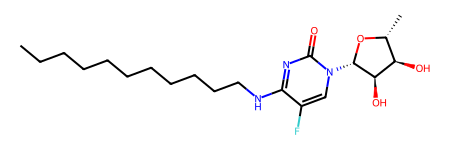

In [59]:
tgt_smiles = "CCCCCCCCCCCNC1=NC(=O)N([C@@H]2O[C@H](C)[C@@H](O)[C@H]2O)C=C1F"
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [60]:
from rdkit.Chem import Draw
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

In [61]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['Ixabepilone + Capecitabine' 'Cytarabine' 'Mitomycin and doxifluridine'
 'TAS-106' 'CDP-choline' 'sapacitabine' 'denufosol tetrasodium (INS37217)'
 'Uridine' 'deoxycytidine' 'LY2334737']
Drug ID ['DB01101' 'DB00987' 'DB12947' 'DB06656' 'DB12153' 'DB06365' 'DB04983'
 'DB02745' 'DB02594' 'DB12906']
Similarity [0.86028789 0.79593721 0.76215278 0.73045603 0.72383253 0.70725806
 0.69907407 0.68902439 0.68342644 0.67960426]


## second generated molecule

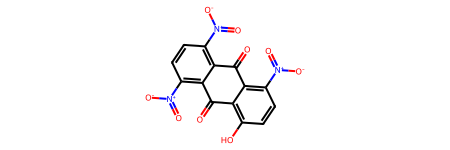

In [63]:
tgt_smiles = "O=C1C2=C(O)C=CC([N+](=O)[O-])=C2C(=O)C2=C([N+](=O)[O-])C=CC([N+](=O)[O-])=C12"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [64]:
from rdkit.Chem import Draw
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

In [65]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['Mitoxantrone hydrochloride' 'AQ4N' 'Emodin' 'Tolcapone'
 '4-Methylpyrazole' 'Niferex' 'ketorolac' 'pixantrone dimaleate' 'C31G'
 'Miltefosine']
Drug ID ['DB01204' 'DB04975' 'DB07715' 'DB00323' 'DB01213' 'DB00139' 'DB03754'
 'DB06193' 'DB05398' 'DB09031']
Similarity [0.67101584 0.66728281 0.63081009 0.57548387 0.53125    0.53125
 0.53125    0.52880482 0.52173913 0.51574803]


### generated molecule

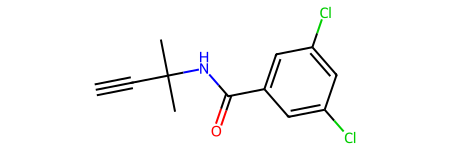

In [61]:
tgt_smiles = "C#CC(C)(C)NC(=O)C1=CC(Cl)=CC(Cl)=C1"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [62]:
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

In [46]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['CPI-1189' 'procarbazine hydrochloride' 'Moclobemide' 'Emeramide'
 'METOCLOPRAMIDE' 'dexloxiglumide' 'procainamide'
 'Aminohippurate Sodium Inj 20%' 'JNJ-31001074' 'bezafibrate + diflunisal']
Drug ID ['DB12311' 'DB01168' 'DB01171' 'DB12192' 'DB01233' 'DB04856' 'DB01035'
 'DB00345' 'DB12299' 'DB01393']
Similarity [0.61980831 0.6097561  0.58675079 0.57432432 0.57425743 0.57416268
 0.56291391 0.56065574 0.55027933 0.54787234]


NameError: name 'CPI' is not defined